In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [113]:
# Trade data

stock_name = 'MSFT.O'

df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [114]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [127]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
dates_final = []
stocks = []
daily_return = []
auction_log_returns = []
auction_log_returns_340350 = []
daily_volatility = []
daily_volatility_minus4pm = []
# daily_volatility2 = []
# daily_volatility2_minus4pm = []
avg_20day_volatility = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    
    # Garman and Klass Volatility formula
    apple_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    
    volatility_today = apple_today_10min['Volatility'].values
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Daily raw return
    daily_return.append(return_today)
        
    # Auction Volatility Information
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility.append(sum(volatility_today))
    daily_volatility_minus4pm.append(sum(volatility_today[:-1]))
#     daily_volatility2.append(np.sqrt(0.5*np.square(np.log(max(apple_today_10min['High'])/min(apple_today_10min['Low']))) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close'][-1]/apple_today_10min['Open'][0]))))
#     daily_volatility2_minus4pm.append(np.sqrt(0.5*np.square(np.log(max(apple_today_10min['High'][:-1])/min(apple_today_10min['Low'][:-1]))) - (2*np.log(2)-1)*np.square(np.log(apple_today_10min['Close'][-2]/apple_today_10min['Open'][0]))))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

stocks200 = stocks.T
stocks200 = stocks200[:200].T
avg_20day_volatility200 = avg_20day_volatility[:200]

In [128]:
volatility_df

,Date,daily_volatility,daily_volatility_minus4pm,volatility_ewma20
0,2020-09-01,0.070169,0.067671,None
1,2020-09-02,0.100699,0.098039,0.070169
2,2020-09-03,0.173458,0.164862,0.086197
3,2020-09-04,0.237539,0.232795,0.118239
4,2020-09-08,0.153790,0.149448,0.152679
...,...,...,...,...
246,2021-08-26,0.039290,0.037776,0.045037
247,2021-08-27,0.040836,0.039283,0.044489
248,2021-08-30,0.037410,0.036178,0.044141
249,2021-08-31,0.037983,0.034968,0.0435


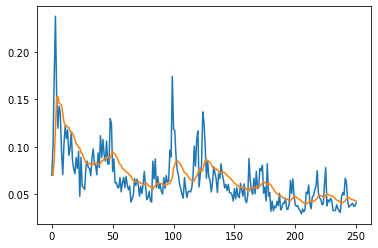

In [129]:
plt.plot(volatility_df['daily_volatility'])
plt.plot(volatility_df['volatility_ewma20'])

In [130]:
# Data Processing (10 minute intervals)

dates_qqq = qqq['Date'].unique()
dates_final_qqq = []
stocks_qqq = []
daily_return_qqq = []
auction_log_returns_qqq = []
auction_log_returns_340350_qqq = []
daily_volatility_qqq = []
daily_volatility_minus4pm_qqq = []
# daily_volatility2_qqq = []
# daily_volatility2_minus4pm_qqq = []
avg_20day_volatility_qqq = []

for date in dates_qqq:
    
    qqq_today = qqq[qqq['Date'] == date]
    qqq_auction_today = auction_qqq[auction_qqq['Date'] == date]
    qqq_today = qqq_today.set_index(pd.DatetimeIndex(qqq_today['Local_Date_Time']))
    qqq_today_10min_max = pd.DataFrame(qqq_today['High'].resample("10T").max())
    qqq_today_10min_min = pd.DataFrame(qqq_today['Low'].resample("10T").min())
    qqq_today_10min_open = pd.DataFrame(qqq_today['Open'].resample("10T").first())
    qqq_today_10min_close = pd.DataFrame(qqq_today['Close'].resample("10T").last())
    qqq_today_10min = qqq_today_10min_max.join(qqq_today_10min_min)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_open)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_close)
    
    # Garman and Klass Volatility formula
    qqq_today_10min['Volatility'] = np.sqrt(0.5*np.square(np.log(qqq_today_10min['High']/qqq_today_10min['Low'])) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])))
#     qqq_today_10min['log_returns'] = abs(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])) # alternate volatility formula
    
    volatility_today_qqq = qqq_today_10min['Volatility'].values
    return_today_qqq = (qqq_today_10min['Close']/qqq_today_10min['Open']).values
    
    if len(volatility_today_qqq) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final_qqq.append(date)
    
    # 10 minute interval volatility * number of complete trade days
    stocks_qqq.append(volatility_today_qqq)
    
    # Daily raw return
    daily_return_qqq.append(return_today_qqq)
        
    # Auction Volatility Information
    auction_log_returns_today_qqq = abs(np.log(qqq_auction_today['Price'].iloc[0]/qqq_today_10min['Open'][-1]))
    auction_log_returns_qqq.append(auction_log_returns_today_qqq)
    
    # Naive Auction Volatility Estimate (Volatility between 3:40pm and 3:50pm)
    auction_log_returns_today_340350_qqq = abs(np.log(qqq_today_10min['Open'][-1]/qqq_today_10min['Open'][-2]))
    auction_log_returns_340350_qqq.append(auction_log_returns_today_340350_qqq)
    
    # Average daily volatility (later used for EWMA 20Day)
    daily_volatility_qqq.append(sum(volatility_today_qqq))
    daily_volatility_minus4pm_qqq.append(sum(volatility_today_qqq[:-1]))
#     daily_volatility2_qqq.append(np.sqrt(0.5*np.square(np.log(max(qqq_today_10min['High'])/min(qqq_today_10min['Low']))) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close'][-1]/qqq_today_10min['Open'][0]))))
#     daily_volatility2_minus4pm_qqq.append(np.sqrt(0.5*np.square(np.log(max(qqq_today_10min['High'][:-1])/min(qqq_today_10min['Low'][:-1]))) - (2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close'][-2]/qqq_today_10min['Open'][0]))))

daily_return_qqq = np.array(daily_return_qqq)
volatility_df_qqq = pd.DataFrame({'Date':dates_final_qqq, 'daily_volatility': daily_volatility_qqq, 'daily_volatility_minus4pm': daily_volatility_minus4pm_qqq})
volatility_df_qqq['volatility_ewma20'] = np.array([None] + [i for i in volatility_df_qqq['daily_volatility'].ewm(span=20).mean()][:-1])

stocks_qqq = stocks_qqq[20:]
stocks_qqq = np.vstack(stocks_qqq).T # Training data for Anderson model
avg_20day_volatility_raw_qqq = np.array(volatility_df_qqq['volatility_ewma20'])
avg_20day_volatility_qqq = np.array(volatility_df_qqq['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

stocks_qqq = stocks_qqq.T
stocks200_qqq = stocks_qqq[:200].T
avg_20day_volatility200_qqq = avg_20day_volatility_qqq[:200]


In [131]:
volatility_df_qqq

,Date,daily_volatility,daily_volatility_minus4pm,volatility_ewma20
0,2020-09-01,0.047841,0.045935,None
1,2020-09-02,0.072500,0.071110,0.047841
2,2020-09-03,0.142873,0.137576,0.060787
3,2020-09-04,0.196657,0.192268,0.090929
4,2020-09-08,0.137248,0.134353,0.121451
...,...,...,...,...
246,2021-08-26,0.034101,0.033062,0.032298
247,2021-08-27,0.026798,0.025828,0.03247
248,2021-08-30,0.021723,0.021018,0.03193
249,2021-08-31,0.028192,0.027129,0.030958


In [132]:
# Calculating beta for the stock (USE VOLATILITY TO VOLATILITY)
daily_beta = []

for i in range(251):
    today_corr = np.corrcoef(daily_return[i][:-1], daily_return_qqq[i][:-1])[1][0]
    today_beta = today_corr * np.sqrt(np.var(daily_return[i])) / np.sqrt(np.var(daily_return_qqq[i]))
    daily_beta.append(today_beta)


In [133]:
from Module.baseModule.bayesFlexibleFourier import *

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Hyper-parameter tuning
for J in [3,4,5,6]:
    for P in [16,17]:
        fourier = flexible_fourier_regression(N=39, di=[], J=J, P=P) # 39 10-minute intervals in each trade day
        res = fourier.train(stocks, avg_20day_volatility, 0.0000005)
        results = []
        for n in range(200,231):
            result = fourier.predict(avg_20day_volatility[n])
            results.append(result[-1][0])
        
        print(J,P)
        print(mean_squared_error(np.array(auction_log_returns[220:]), results))
        print(mean_absolute_error(np.array(auction_log_returns[220:]), results))
        print(r2_score(np.array(auction_log_returns[220:]), results))
        print()

# 4 15
# 1.3869869459451482e-06
# 0.0009264672343845342
# -0.14767650877285154

# 4 20
# 6.620750182250775e-06
# 0.0020605466551422637
# -4.478407332409955

# 4 25
# 8.284473901442754e-06
# 0.0023395062806897096
# -5.85507250953149

# 3 10
# 3.1143525431366282e-06
# 0.001576436201094502
# -1.5770028075925744

# 3 15
# 1.382159647592918e-06
# 0.000925459717974778
# -0.1436821114673188

# 4 10
# 3.1599738022220716e-06
# 0.00159101642166723
# -1.6147525841900205

# 3 16
# 1.5919254621344497e-06
# 0.0009587537900937506
# -0.31725497629977517


In [253]:
########### FOURIER STOCK ###########

fourier = flexible_fourier_regression(N=39, di=[], J=3, P=15) # 39 10-minute intervals in each trade day
res = fourier.train(stocks200, avg_20day_volatility200, 0.0000005)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.8f}".format(res.fun))

optimizer success: True
objective function (mse): 0.00000191


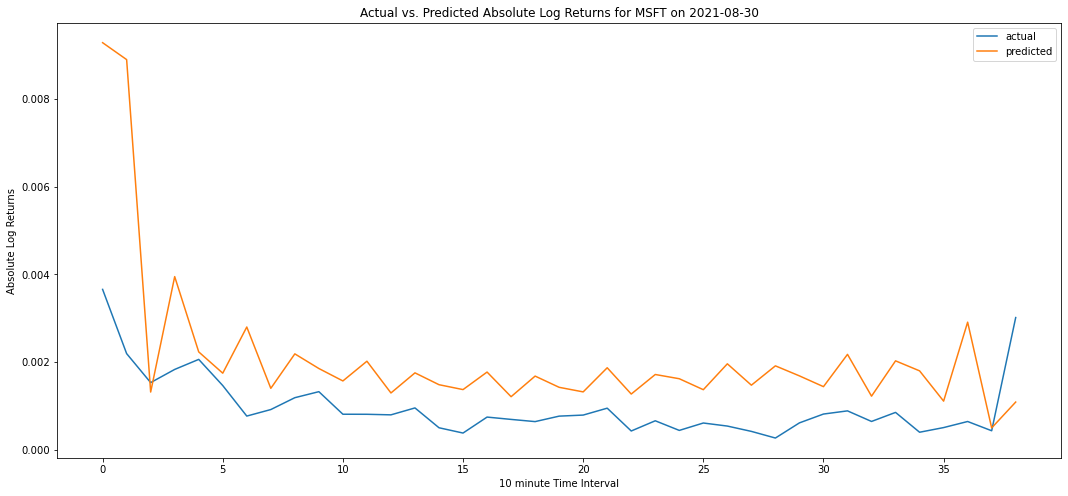

In [283]:
n=229
result = fourier.predict(avg_20day_volatility[n])

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(stocks.T[n], label="actual")
ax.plot(result, label="predicted")
plt.xlabel("10 minute Time Interval")
plt.ylabel("Absolute Log Returns")
plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
ax.legend()

In [251]:
results = [None for i in range(20)]
results_full = []

for vol in avg_20day_volatility:
    result = fourier.predict(vol)
    results_full.append(np.array([res[0] for res in result]))
    results.append(result[-1][0])
    
results = np.array(results)
results_full = np.array(results_full)

In [288]:
actual = stocks.T[-31:,38]
predicted = np.array([fourier.predict(avg_20day_volatility[n])[-1][0] for n in range(200,231)])
print(mean_absolute_error(actual, predicted))
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))

0.0005575410781680581
5.676305201381382e-07
-0.5738409305509986


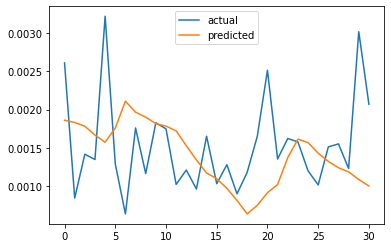

In [289]:
plt.plot(actual, label="actual")
plt.plot(predicted, label="predicted")
plt.legend()

Model fit success: True


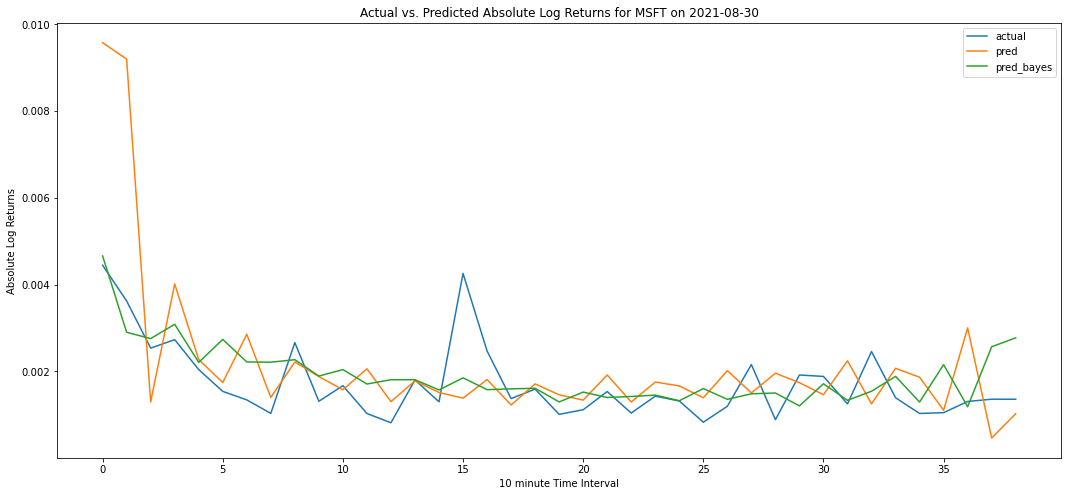

In [252]:
n=221

# After Bayes
bayes_dayVol = fourier.vol_update(stocks.T[n,:39], sum(stocks.T[n,:39]) * 39/38, tol=1e-7)
bayes_result = fourier.predict(bayes_dayVol)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(stocks.T[n], label="actual")
ax.plot(results_full[n], label="pred")
ax.plot(bayes_result, label="pred_bayes")
plt.xlabel("10 minute Time Interval")
plt.ylabel("Absolute Log Returns")
plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
ax.legend()

In [293]:
from copy import deepcopy

# Before Bayes
fourier = flexible_fourier_regression(N=39, di=[], J=3, P=15) # 39 10-minute intervals in each trade day
res = fourier.train(stocks200, avg_20day_volatility200, 0.0000005)
predicted2 = []

for n in range(200,231):

    fourier_copy = deepcopy(fourier)

    # After Bayes
    bayes_dayVol = fourier_copy.vol_update(stocks.T[n,:39], sum(stocks.T[n,:39]) * 39/38, tol=1e-7)
    bayes_result = fourier_copy.predict(bayes_dayVol)
    predicted2.append(bayes_result[-1][0])

#     print(n)
#     print('Before Bayes:', abs(stocks.T[n][-1] - results_full[n][-1]))
#     print('After Bayes:', abs(stocks.T[n][-1] - bayes_result[-1]))
#     print()

Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True
Model fit success: True


In [295]:
print(mean_absolute_error(actual, predicted2))
print(mean_squared_error(actual, predicted2))
print(r2_score(actual, predicted2))

0.0010242277203807977
1.2352969196299064e-06
-2.4250463717560224


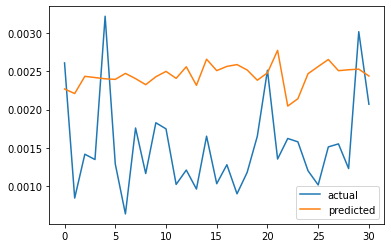

In [296]:
plt.plot(actual, label="actual")
plt.plot(predicted2, label="predicted")
plt.legend()

In [325]:
df_mod2C = pd.DataFrame()
df_mod2C['Date'] = volatility_df['Date'][-32:]
df_mod2C['daily_volatility'] = volatility_df['daily_volatility'][-32:]
df_mod2C['daily_volatility_minus4pm'] = volatility_df['daily_volatility_minus4pm'][-32:]
df_mod2C['auction'] = df_mod2C['daily_volatility'] - df_mod2C['daily_volatility_minus4pm']
df_mod2C['daily_volatility_minus4pm_yest'] = df_mod2C['daily_volatility_minus4pm'].shift(1)
df_mod2C['fourier_volatility_yest'] = np.array([None] + [val for val in predicted])
df_mod2C['fourier_volatility_2c'] = df_mod2C['daily_volatility_minus4pm']/df_mod2C['daily_volatility_minus4pm_yest']*df_mod2C['fourier_volatility_yest']
df_mod2C = df_mod2C[1:]
df_mod2C

,Date,daily_volatility,daily_volatility_minus4pm,auction,daily_volatility_minus4pm_yest,fourier_volatility_yest,fourier_volatility_2c
220,2021-07-21,0.046451,0.043842,0.002609,0.048728,0.001862,0.001675
221,2021-07-22,0.044752,0.043905,0.000847,0.043842,0.001832,0.001835
222,2021-07-23,0.039148,0.037730,0.001418,0.043905,0.001783,0.001533
223,2021-07-26,0.040335,0.038986,0.001349,0.037730,0.001668,0.001723
224,2021-07-27,0.061181,0.057964,0.003217,0.038986,0.001575,0.002342
225,2021-07-28,0.078231,0.076939,0.001292,0.057964,0.00176,0.002336
226,2021-07-29,0.038092,0.037452,0.000640,0.076939,0.002111,0.001027
227,2021-07-30,0.044265,0.042505,0.001760,0.037452,0.001966,0.002231
228,2021-08-02,0.042174,0.041007,0.001167,0.042505,0.001902,0.001835
229,2021-08-03,0.046012,0.044184,0.001828,0.041007,0.001816,0.001957


In [327]:
predicted3 = df_mod2C['fourier_volatility_2c']

print(mean_absolute_error(actual, predicted3))
print(mean_squared_error(actual, predicted3))
print(r2_score(actual, predicted3))

0.000501721345794054
4.594258571399436e-07
-0.2738272394943717


In [140]:
########### FOURIER QQQ ###########

fourier_qqq = flexible_fourier_regression(N=39, di=[], J=3, P=15) # 39 10-minute intervals in each trade day
res = fourier.train(stocks200_qqq, avg_20day_volatility200_qqq, 0.0000005)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.8f}".format(res.fun))

optimizer success: True
objective function (mse): 0.00000129


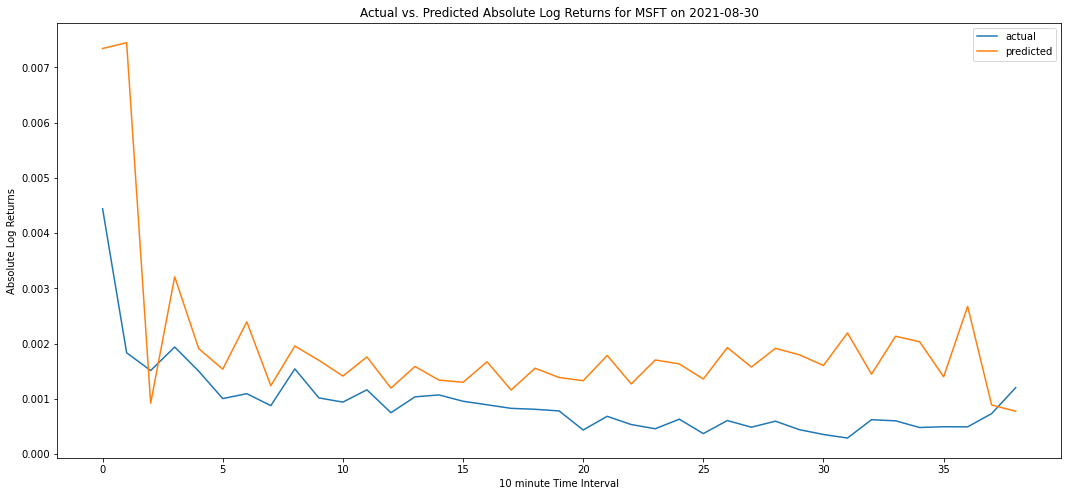

In [141]:
n=224
result = fourier.predict(avg_20day_volatility_qqq[n])

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(stocks.T[n], label="actual")
ax.plot(result, label="predicted")
plt.xlabel("10 minute Time Interval")
plt.ylabel("Absolute Log Returns")
plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
ax.legend()

In [143]:
results_qqq = [None for i in range(20)]
results_qqq_full = []

for vol in avg_20day_volatility_qqq:
    result = fourier_qqq.predict(vol)
    results_qqq_full.append(np.array([res[0] for res in result]))
    results_qqq.append(result[-1][0])
results_qqq = np.array(results_qqq)
results_qqq_full = np.array(results_qqq_full)

In [151]:
# Simple linear regression with Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final,     
    'Daily_Volatility': volatility_df['daily_volatility'],
    'Daily_Volatility_minus4pm': volatility_df['daily_volatility_minus4pm'],

    'Daily_Volatility_qqq': volatility_df_qqq['daily_volatility'],
    'Daily_Volatility_qqq_minus4pm': volatility_df_qqq['daily_volatility_minus4pm'],
    
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Avg20_Volatility_qqq': avg_20day_volatility_raw_qqq, 
    
    'Beta': daily_beta,
    'Anderson': results,
    'Anderson_qqq': results_qqq,
    'Auction_Log_Returns': auction_log_returns
})